In [1]:
import torch
%load_ext autoreload
import neptune.new as neptune
from trainers import timegan_generate_data, rtsgan_generator, rgan_generator
from utils import *

# Makes sure the same testset is generated every time
np.random.seed(42)
alpha = 0.7
noise = 0
testset = DatasetSinus(num=600, seq_len=100, alpha=alpha, noise=noise)

In [389]:
%autoreload
# Models
from architectures.timegan_cnn_DG import *
#from architectures.timegan_cnn_D import *
#from architectures.timegan_cnn_G import *
#from architectures.timegan_cnn_DGER import *
#from architectures.RGAN import *
#from architectures.RTSGAN import *

print(f"Loading architecture: {ID}")

Loading architecture: TimeGAN_DG


In [390]:
id = "TIMEGAN-84" # RTSGAN-66
project_name = "timeGAN" # RTSGAN

run = neptune.init_run(
                with_id=id, # "TIMEGAN-84"
                project="kohmann/" + project_name,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
                   )
params = run["parameters"].fetch()
params["device"] = "cpu"
params["testset_size"] = len(testset)
#params["model_name"] = "model_checkpoint.pt"

if "TimeGAN" in ID:
    model = TimeGAN(params)
elif ID == "RGAN":
    model = RGAN(params)
elif ID == "RTSGAN":
    model = RTSGAN(params)
else:
    raise ValueError
model = restore_weights(model, run)


https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-84
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-84


In [392]:
id.split('-')[-1]

'84'

In [8]:
%autoreload
#fake_data = rtsgan_generator(model, params, eval=True)
fake_data = timegan_generate_data(model, torch.tensor(testset.T), params["max_seq_len"], params["Z_dim"])

#### Evaluation methods

https://app.neptune.ai/kohmann/Evaluation/e/EV-4
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
MSE Error: 0.00461
Mean Wasserstein/Sinkhorn distance: 0.0143 ± 0.0059
Mean MMD: 0.0112 ± 0.0020


/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
All 3 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/Evaluation/e/EV-4


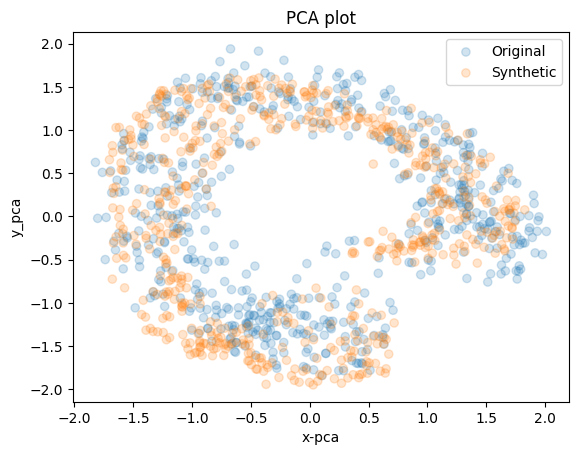

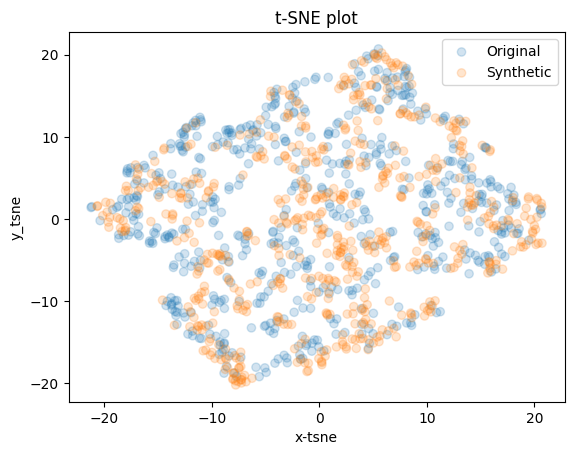

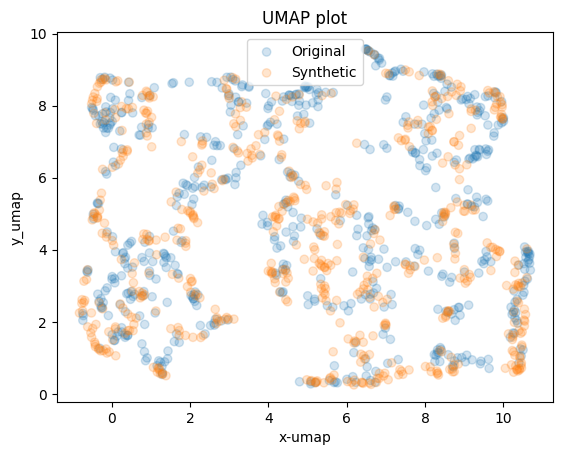

In [393]:
run = neptune.init_run(
    project="kohmann/Evaluation",
    name=ID,
    description="",
    #source_files=["architectures/RTSGAN.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)
run["model_id"] = ID + "-" + id.split('-')[-1]
from metrics import compare_sin3_generation, sinkhorn_distance, MMD
mse_error = compare_sin3_generation(fake_data, 0.7, 0)
print(f"MSE Error: {mse_error:.5f}")
x = torch.tensor(fake_data)
y = testset[:][0]
wass_dist = sinkhorn_distance(x,y)
mmd = MMD(x,y)
print(f"Mean Wasserstein/Sinkhorn distance: {wass_dist.mean():.4f} ± {wass_dist.std():.4f}")
print(f"Mean MMD: {mmd.mean():.4f} ± {mmd.std():.4f}")


run["numeric_results/num_test_samples"] = len(testset)
run["numeric_results/sin3_generation_MSE_loss"] = mse_error
run["numeric_results/wasserstein_distance_mean"] = wass_dist.mean()
run["numeric_results/wasserstein_distance_std"] = wass_dist.std()
run["numeric_results/MMD_mean"] = mmd.std()
run["numeric_results/MMD_std"] = mmd.std()

r = np.array([data[0].numpy() for data in testset])
#sin = None
#f_pca = visualization(r[:,:,sin][:,:,None], fake_data[:,:,sin][:,:,None], 'umap')
run["PCA"].upload(visualization(r, fake_data, 'pca'))
run["tSNE"].upload(visualization(r, fake_data, 'tsne'))
run["UMAP"].upload(visualization(r, fake_data, 'umap'))
run.stop()

In [194]:
%autoreload
from metrics import compare_sin3_generation, sinkhorn_distance, MMD
mse_error = compare_sin3_generation(fake_data, 0.7, 0)
print(f"MSE Error: {mse_error:.5f}")
x = torch.tensor(fake_data, dtype=torch.float32)
y = testset[:][0]
wass_dist = sinkhorn_distance(x,y, blur=0.01)
mmd = MMD(x,y)
print(f"Mean Wasserstein/Sinkhorn distance: {wass_dist.mean():.8f} ± {wass_dist.std():.8f}")
print(f"Mean MMD: {mmd.mean():.6f} ± {mmd.std():.6f}")

MSE Error: 0.00461
Mean Wasserstein/Sinkhorn distance: 0.014340542256832123 ± 0.005942
Mean MMD: 0.011161 ± 0.002044


In [193]:
wass_dist.mean().numpy(), wass_dist.numpy().mean()

(array(0.01434054, dtype=float32), 0.01434054)

In [14]:
x = torch.tensor(fake_data, dtype=torch.float32)[0]
y = testset[:][0][0]

In [130]:
sin1 = DatasetSinus(num=600, seq_len=100, alpha=alpha, noise=noise, s1_freq=)[:][0]
sin2 = x[:, :, :]
print("sin1.size():", sin1.size())
sinkhorn_distance(sin1[None, :300], sin1[None, -300:])

sin1.size(): torch.Size([600, 3, 100])


ValueError: Input samples 'x' and 'y' should be encoded as (N,D) or (B,N,D) (batch) tensors.

In [2]:
# How the sequence length affect the wasserstein distance on two 1-dim curves
    # answer: Does vary alot
n_dist = list()

for N in range(2,101):
    t = torch.linspace(0, 2 * np.pi, N, dtype=torch.float32)
    x = t.sin() #+  0.05 * torch.randn(N)
    y = t.cos()
    #plt.scatter(t,x, alpha=0.2)
    #plt.scatter(t,y, alpha=0.2)
    wass = sinkhorn_distance(x[:, None], y[:, None]).numpy()
    n_dist.append(wass)
plt.plot(range(2,101), n_dist)
plt.yscale("log")

NameError: name 'sinkhorn_distance' is not defined

In [385]:
# what if reshape the arrays of being of [B,1,N]

seq_len = 100
max_samples = 1000
N = 20
batch = 1000
x, y = list(), list()
for i in range(batch):
    t = torch.linspace(0, 2 * np.pi, N, dtype=torch.float32)
    x_i = t.sin() +  0.05 * torch.randn(N)
    y_i = t.cos() +  0.05 * torch.randn(N)
    x.append(x_i)
    y.append(y_i)
x = torch.stack(x)#.permute(1,0)
y = torch.stack(y)#.permute(1,0)
x.size()

torch.Size([1000, 20])

In [386]:
t = torch.linspace(0, 2 * np.pi, N, dtype=torch.float32)
#plt.scatter(t,x[0, :], alpha=0.2)
#plt.scatter(t,y[0], alpha=0.2)
wass = sinkhorn_distance(x, y).numpy()
wass

array(10.018303, dtype=float32)

In [312]:
x = testset[:][0]

In [313]:
x.size()

torch.Size([600, 100, 3])

In [317]:
data = testset[:][0]
x = data[:50]
y = data[-50:]

(tensor([[0.7917, 0.7229, 0.0679,  ..., 0.7283, 0.2193, 0.6370],
         [0.4508, 0.5525, 0.7200,  ..., 0.5259, 0.5412, 0.3197],
         [0.3983, 0.3751, 0.5002,  ..., 0.2115, 0.6181, 0.7640],
         ...,
         [0.5099, 0.6443, 0.3623,  ..., 0.4691, 0.3205, 0.7982],
         [0.0505, 0.0966, 0.7709,  ..., 0.1534, 0.7931, 0.7199],
         [0.4720, 0.3130, 0.4851,  ..., 0.3893, 0.6261, 0.6288]]),
 torch.Size([50, 100, 3]))

In [365]:
def cost_xy(x, y, scaling_coef):
    '''
    L2 distance between vectors, using expanding and hence is more memory intensive
    :param x: x is tensor of shape [batch_size, time steps, features]
    :param y: y is tensor of shape [batch_size, time steps, features]
    :param scaling_coef: a scaling coefficient for distance between x and y
    :return: cost matrix: a matrix of size [batch_size, batch_size] where
    '''
    x = torch.unsqueeze(x, 1)
    y = torch.unsqueeze(y, 0)
    sum_over_pixs = torch.sum((x - y)**2, -1) * scaling_coef
    sum_over_time = torch.sum(sum_over_pixs, -1)
    return sum_over_time

def benchmark_sinkhorn(x, y, scaling_coef, epsilon=1.0, L=10, Lmin=10):
    '''
    Given two emprical measures with n points each with locations x and y
    outputs an approximation of the OT cost with regularization parameter epsilon
    niter is the max. number of steps in sinkhorn loop
    '''
    n_data = x.shape[0]

    # The Sinkhorn algorithm takes as input three variables :
    C = cost_xy(x, y, scaling_coef)  # Wasserstein cost function

    # both marginals are fixed with equal weights
    mu = 1.0 / torch.tensor(n_data, dtype=torch.float32) * torch.ones(n_data, dtype=torch.float32)
    nu = 1.0 / torch.tensor(n_data, dtype=torch.float32) * torch.ones(n_data, dtype=torch.float32)

    # Parameters of the Sinkhorn algorithm.
    thresh = 10**(-2)  # stopping criterion

    # Elementary operations .....................................................................
    def M(u, v):
        '''
        Modified cost for logarithmic updates
        $M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$
        '''
        return (-C + u[:,None] + v[None,:]) / epsilon

    def lse(A):
        '''
        log-sum-exp
        '''
        return A.logsumexp(dim=1, keepdim=True)
        # return tf.math.log(tf.reduce_sum(tf.exp(A), axis=1, keepdims=True) + 1e-6)  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * mu, 0. * nu, 0.

    for i in range(L):
        u1 = u  # useful to check the update
        u = epsilon * (torch.log(mu) - torch.squeeze(lse(M(u, v)))) + u
        #print(M(u, v).transpose)
        v = epsilon * (torch.log(nu) - torch.squeeze(lse(torch.transpose(M(u, v), 0, 1)))) + v
        err =torch.sum(torch.abs(u - u1))
        if torch.greater(torch.tensor(thresh), err) and i >= Lmin:
            break
    U, V = u, v
    pi = torch.exp(M(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    cost = torch.sum(pi * C)  # Sinkhorn cost
    return cost

In [366]:
benchmark_sinkhorn(x, y, 0.05)

tensor(1.5653)